In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import numpy as np 
import os
import random
from skimage.util import random_noise
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

%matplotlib inline

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18109489360757972069
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11145641984
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2357603141982424519
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [11]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [12]:
# print(os.listdir("../input/skin-seg-data"))

['validation', 'training']


In [13]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import backend as K

%matplotlib inline

In [14]:
background_tissue = [0,0,0]
instrument_shaft = [0,255,0]
instrument_clasper = [0,255,255]
instrument_wrist = [125,255,12]
kidney_parenchyma = [255,55,0]
covered_kidney = [24,55,125]
thread = [187,155,25]
clamps = [ 0,255,125]
suturing_needle = [255,255,125]
suction_instrument = [123,15,175]
small_intestine = [124,155,5]
ultrasound_probe = [12,255,141]

COLOR_DICT = np.array([background_tissue,instrument_shaft, instrument_clasper, instrument_wrist, kidney_parenchyma,
                          covered_kidney, thread, clamps, suturing_needle, suction_instrument, small_intestine, ultrasound_probe])

In [15]:
target_size = (224,320)
batch_size = 32
epochs = 2
optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [16]:
def image_preprocess(image):
    image = image.astype(np.float32) / 255.0
    image = image - random.uniform(0, 0.6) 
    image = random_noise(image, mode='gaussian', seed=None, clip=True)
    return image

def mask_preprocess(mask):
    mask = mask.astype(np.float32) / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return mask

def data_generator(batch_size,
                   params_dict,
                   train_path,
                   image_folder, mask_folder,
                   save_path = None,
                   image_save_prefix  = "image", mask_save_prefix  = "mask",
                   target_size = target_size,
                   seed = 1):
    '''
    generates augmented image and mask on the fly at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    '''
    
    image_datagen = ImageDataGenerator(**params_dict, preprocessing_function = image_preprocess)
    mask_datagen = ImageDataGenerator(**params_dict, preprocessing_function = mask_preprocess)
    
    training_image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_path,
        save_prefix  = image_save_prefix,
        shuffle = False,
        interpolation = 'bicubic',
        seed = seed)
    
    training_mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_path,
        save_prefix  = mask_save_prefix,
        shuffle = False,
        interpolation = 'bicubic',
        seed = seed)
    
    # returning zip(generator_one, generator_two) in turn also creates generator
    return zip(training_image_generator, training_mask_generator)

In [17]:
train_dir= "data/training"
validation_dir= "data/validation"
augmented_dir= 'data/augmented'

In [18]:
data_augmentation_args = dict(rotation_range=45,
                              width_shift_range=10,
                              height_shift_range=10,
                              shear_range=0.05,
                              zoom_range=0.05,
                              horizontal_flip=False,
                              fill_mode='nearest')

train_generator = data_generator(batch_size, data_augmentation_args, train_dir, 'images', 'masks',augmented_dir)
validation_generator = data_generator(batch_size, data_augmentation_args, validation_dir, 'images', 'masks',augmented_dir)



Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.


In [8]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 224
img_cols = 320

smooth = 1.



In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Specificity(y_true, y_pred):
    true_negatives = K.abs(y_pred)- K.abs(y_true)
    return ((true_negatives+smooth)/(y_pred+ smooth))

def Sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return ((y_pred+smooth)/ (y_true+smooth))

def Jaccard_index(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))


In [10]:
def unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer= optimizer, loss=dice_coef_loss, metrics=[dice_coef, 'acc',Jaccard_index, Specificity, Sensitivity, precision, recall, f1score])

    return model

In [11]:
model = unet()
model_checkpoint = ModelCheckpoint('unet_endovis.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [12]:
history = model.fit_generator(train_generator, epochs = epochs, verbose=1, shuffle=True,
          steps_per_epoch= 400,
          validation_data = validation_generator,
          validation_steps=100,
          callbacks=[model_checkpoint])

Epoch 1/2
400/400 [==============================] - 12869s 32s/step - loss: -0.4487 - dice_coef: 0.4487 - acc: 0.5823 - Jaccard_index: 0.3013 - Specificity: 0.8576 - Sensitivity: 1.3398 - precision: 0.3988 - recall: 0.8152 - f1score: 0.5069 - val_loss: -0.7425 - val_dice_coef: 0.7425 - val_acc: 0.8454 - val_Jaccard_index: 0.5908 - val_Specificity: 0.7770 - val_Sensitivity: 0.9893 - val_precision: 0.8400 - val_recall: 0.6704 - val_f1score: 0.7450

Epoch 00001: loss improved from inf to -0.44875, saving model to unet_endovis.hdf5
Epoch 2/2
400/400 [==============================] - 12414s 31s/step - loss: -0.7621 - dice_coef: 0.7621 - acc: 0.8917 - Jaccard_index: 0.6163 - Specificity: 0.8517 - Sensitivity: 1.0164 - precision: 0.7968 - recall: 0.7385 - f1score: 0.7635 - val_loss: -0.7661 - val_dice_coef: 0.7661 - val_acc: 0.8646 - val_Jaccard_index: 0.6210 - val_Specificity: 0.7757 - val_Sensitivity: 0.9650 - val_precision: 0.9113 - val_recall: 0.6618 - val_f1score: 0.7668

Epoch 00002: 

In [13]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  -0.7657264149188996
Test Accuracy:  0.7657264137268066


In [14]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

dice_coef: 76.57%


In [15]:
print(history.history.keys())

dict_keys(['val_loss', 'val_dice_coef', 'val_acc', 'val_Jaccard_index', 'val_Specificity', 'val_Sensitivity', 'val_precision', 'val_recall', 'val_f1score', 'loss', 'dice_coef', 'acc', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score'])


dict_keys(['val_loss', 'val_dice_coef', 'val_acc', 'val_Jaccard_index', 'val_Specificity', 'val_Sensitivity', 'val_precision', 'val_recall', 'val_f1score', 'loss', 'dice_coef', 'acc', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score'])


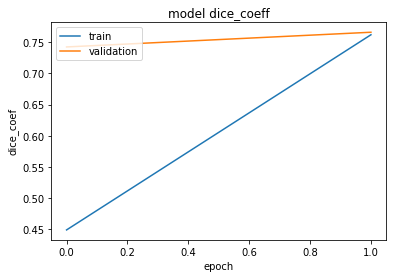

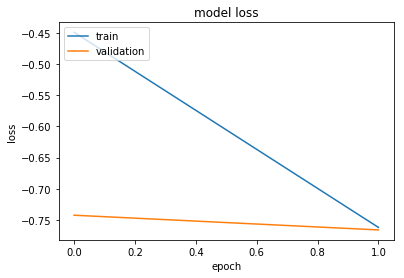

In [16]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coeff')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

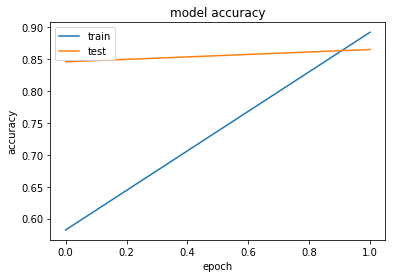

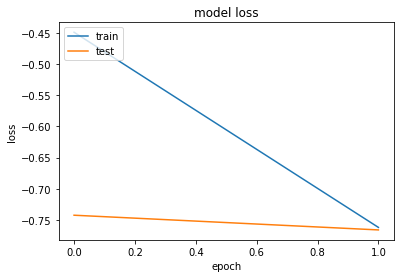

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

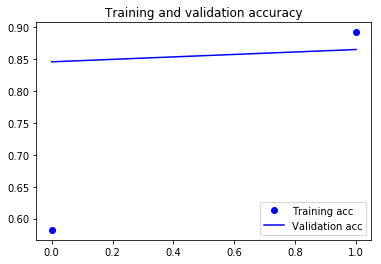

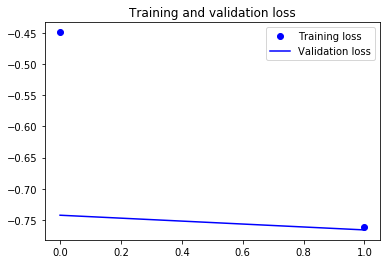

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

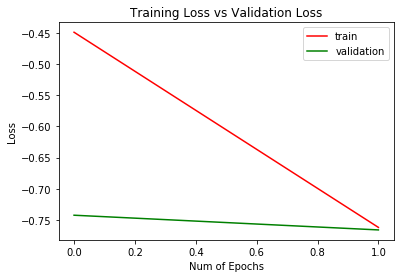

In [19]:
import numpy as np
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')

plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [20]:
prediction = model.predict_generator(validation_generator, verbose=1, steps=10)

10/10 [==============================] - 101s 10s/step


In [21]:
prediction

array([[[[0.2813454 ],
         [0.2082047 ],
         [0.08686188],
         ...,
         [0.06934143],
         [0.18616061],
         [0.21523844]],

        [[0.23333916],
         [0.10251423],
         [0.01507936],
         ...,
         [0.01606864],
         [0.03907156],
         [0.11153699]],

        [[0.0877777 ],
         [0.05918928],
         [0.0026194 ],
         ...,
         [0.00364592],
         [0.02042849],
         [0.04072854]],

        ...,

        [[0.15169035],
         [0.04313786],
         [0.00473803],
         ...,
         [0.00384008],
         [0.01227319],
         [0.06735098]],

        [[0.1775231 ],
         [0.05676247],
         [0.01554298],
         ...,
         [0.01105653],
         [0.04028271],
         [0.08021399]],

        [[0.33601075],
         [0.16416001],
         [0.11913202],
         ...,
         [0.07169247],
         [0.1344285 ],
         [0.24682973]]],


       [[[0.36857763],
         [0.32329878],
         [0.21

In [28]:
len(prediction)

240

In [ ]:
train_generator.

In [29]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
#         io.imsave(os.path.join(save_path, str(image_id) + '_pred.png'), img)

In [31]:
!ls

data  results_dir  skin-seg-unet.ipynb	unet_endovis.hdf5


In [25]:
os.mkdir('results_dir')

In [26]:
!ls

data  results_dir  skin-seg-unet.ipynb	unet_endovis.hdf5


In [32]:
saveResult('results_dir',prediction)

/home/sara/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [ ]:
%cd results_dir/

In [ ]:
!ls

Populating the interactive namespace from numpy and matplotlib


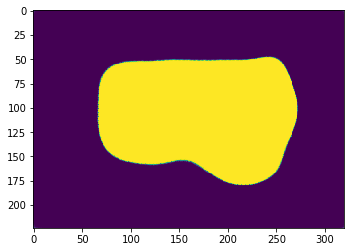

In [35]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('results_dir/35_predict.png')
imgplot = plt.imshow(img)
plt.show()

In [49]:
nb_epoch = 2
import json

experiment_name = "UNet"
img_dim = (target_size,1)
dataset='Endovis'
model_name = "UNet"


In [53]:

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for e in range(nb_epoch):

    new_hi = model.fit_generator(train_generator,
                     steps_per_epoch= 400,
                     validation_data = validation_generator,
                     validation_steps=100,
                     epochs=1)

    train_losses.append(new_hi.history["loss"])
    val_losses.append(new_hi.history["val_loss"])
    train_accs.append(new_hi.history["acc"])
    val_accs.append(new_hi.history["val_acc"])

    # Save experimental log
    d_log = {}
    d_log["experiment_name"] = experiment_name
    d_log["img_dim"] = img_dim
    d_log["batch_size"] = batch_size
    d_log["nb_epoch"] = nb_epoch
    d_log["train_losses"] = train_losses
    d_log["val_losses"] = val_losses
    d_log["train_accs"] = train_accs
    d_log["val_accs"] = val_accs
    d_log["optimizer"] = "Adam"
    # Add model architecture
    json_string = json.loads(model.to_json())
    for key in json_string.keys():
        d_log[key] = json_string[key]
    json_file = os.path.join("log", '%s_%s_%s.json' % (dataset, model.name, experiment_name))
    with open(json_file, 'w') as fp:
        json.dump(d_log, fp, indent=4, sort_keys=True)

Epoch 1/1
400/400 [==============================] - 12990s 32s/step - loss: -0.8069 - dice_coef: 0.8069 - acc: 0.9085 - Jaccard_index: 0.6765 - Specificity: 0.8595 - Sensitivity: 1.0240 - precision: 0.8068 - recall: 0.8096 - f1score: 0.8071 - val_loss: -0.8132 - val_dice_coef: 0.8132 - val_acc: 0.8820 - val_Jaccard_index: 0.6852 - val_Specificity: 0.7924 - val_Sensitivity: 0.9988 - val_precision: 0.8696 - val_recall: 0.7639 - val_f1score: 0.8133
Epoch 1/1
400/400 [==============================] - 13085s 33s/step - loss: -0.8172 - dice_coef: 0.8172 - acc: 0.9130 - Jaccard_index: 0.6912 - Specificity: 0.8616 - Sensitivity: 1.0253 - precision: 0.8116 - recall: 0.8255 - f1score: 0.8174 - val_loss: -0.8237 - val_dice_coef: 0.8237 - val_acc: 0.8853 - val_Jaccard_index: 0.7004 - val_Specificity: 0.7981 - val_Sensitivity: 1.0125 - val_precision: 0.8521 - val_recall: 0.7975 - val_f1score: 0.8239


In [54]:
pred_dir = "results_dir2"
# imgs_mask_pred = model.predict(imgs_pred, verbose=1)
np.save(pred_dir+'/imgs_test.npy', prediction)

for idx, image in enumerate(prediction):
    max = np.max(image[:,:,0])
    min = np.min(image[:,:,0])
    #image = (255*(image[:, :, 0]-min)/(max-min)).astype(np.uint8)
    imageio.imsave(os.path.join(pred_dir, 'prediction_0_' + str(idx) + '_pred.jpg'), image[:,:,0])

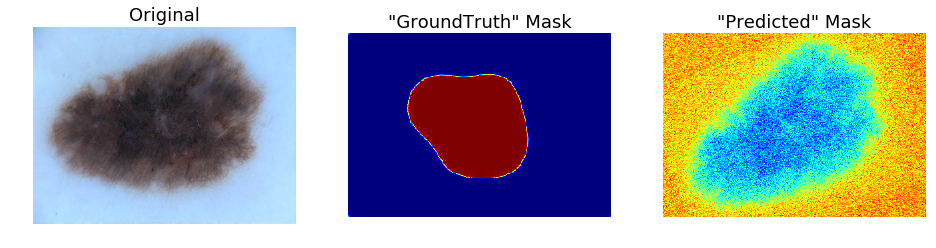

In [119]:
# https://www.kaggle.com/pestipeti/explanation-of-scoring-metric

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio

from scipy import ndimage
from pathlib import Path

img= plt.imread("data/training/images/ISIC_0000000.jpg")
target_mask = plt.imread("results_dir2/prediction_0_69_pred.jpg")
pred_mask = plt.imread("data/augmented/image_0_10533.png")


# Plot the objects
# plt.imshow(im.reshape(im.shape[0], im.shape[1]), cmap=plt.cm.Greys)

fig, axes = plt.subplots(1,3, figsize=(16,9))
axes[0].imshow(img)
axes[1].imshow(target_mask,cmap='jet')
axes[2].imshow(pred_mask, cmap='jet')

labels = ['Original', '"GroundTruth" Mask', '"Predicted" Mask']
for ind, ax in enumerate(axes):
    ax.set_title(labels[ind], fontsize=18)
    ax.axis('off')

In [71]:
img_path = "data/training/images/ISIC_0000000.jpg"
target_mask_path = "results_dir2/prediction_0_69_pred.jpg"
predicted_mask_path = "data/training/masks/ISIC_0000000_segmentation.png"

im = plt.imread(img_path)
im.max()

255

In [72]:
gt = plt.imread(target_mask_path)

In [73]:
gt.min()

0

In [74]:
im.mean()

150.31926942340223

In [92]:
import numpy as np


def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.", "image1 shape:", im1.shape,"image2 shape:", im2.shape)

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [99]:
groundTruth = plt.imread("results_dir2/prediction_0_69_pred.jpg")
resultImage = plt.imread("data/augmented/image_0_10533.png")

In [100]:
resultImage = (resultImage - resultImage.min()) / (resultImage.max() - resultImage.min())
groundTruth = (groundTruth - groundTruth.min()) / (groundTruth.max() - groundTruth.min())

In [101]:
dice(resultImage, groundTruth)

0.36825750936180385

In [102]:
resultImage.shape

(224, 320)

In [103]:
groundTruth.shape

(224, 320)

In [104]:
groundTruth.ndim

2

In [105]:
groundTruth.ndim

2

In [108]:
target_mask = plt.imread("results_dir2/prediction_0_69_pred.jpg")
pred_mask = plt.imread("data/augmented/image_0_10533.png")

**#### Intersection Over Union (for a single Prediction-GroundTruth comparison)**

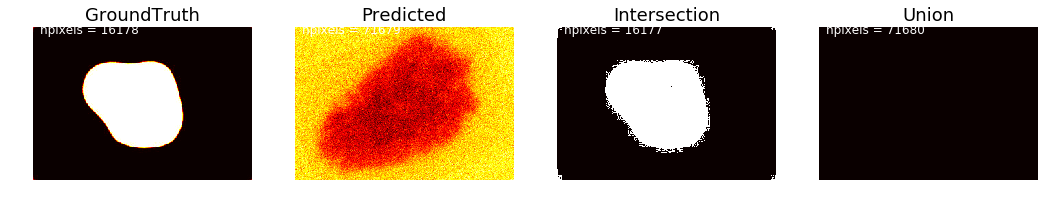

In [111]:
A = target_mask
B = pred_mask
intersection = np.logical_and(A, B)
union = np.logical_or(A, B)

fig, axes = plt.subplots(1,4, figsize=(18,12))
axes[0].imshow(A, cmap='hot')
axes[0].annotate('npixels = {}'.format(np.sum(A>0)), 
                 xy=(10, 10), color='white', fontsize=12)
axes[1].imshow(B, cmap='hot')
axes[1].annotate('npixels = {}'.format(np.sum(B>0)), 
                 xy=(10, 10), color='white', fontsize=12)

axes[2].imshow(intersection, cmap='hot')
axes[2].annotate('npixels = {}'.format(np.sum(intersection>0)), 
                 xy=(10, 10), color='white', fontsize=12)

axes[3].imshow(union, cmap='hot')
axes[3].annotate('npixels = {}'.format(np.sum(union>0)), 
                 xy=(10, 10), color='white', fontsize=12)

labels = ['GroundTruth', 'Predicted', 'Intersection', 'Union']
for ind, ax in enumerate(axes):
    ax.set_title(labels[ind], fontsize=18)
    ax.axis('off')

In [113]:
def histdata(accuracy):
    numvalues, x = np.histogram(accuracy, bins=np.arange(0,1.1,0.1))
    print("Accuracy  :   No. of predictions\n")
    for i in range(len(numvalues)):
        print("{:03.1f} - {:03.1f} : {:>4}".format(x[i],x[i+1],numvalues[i]))

In [114]:
histdata(prediction)

Accuracy  :   No. of predictions

0.0 - 0.1 : 12862460
0.1 - 0.2 : 49939
0.2 - 0.3 : 31681
0.3 - 0.4 : 25054
0.4 - 0.5 : 22634
0.5 - 0.6 : 22849
0.6 - 0.7 : 24928
0.7 - 0.8 : 30612
0.8 - 0.9 : 47074
0.9 - 1.0 : 4085969


In [115]:
print("Mean Accuracy:",np.mean(prediction))
print("Accuracy > 0.8 :", np.mean(prediction>=0.8)*100,"%")

Mean Accuracy: 0.24493402
Accuracy > 0.8 : 24.02485002790179 %


In [117]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff

target_mask = plt.imread("results_dir2/prediction_0_69_pred.jpg")
pred_mask = plt.imread("data/augmented/image_0_10533.png")

gt = np.asarray(target_mask).astype(np.bool)
pred = np.asarray(pred_mask).astype(np.bool)

intersection = np.logical_and(gt, pred)
print("Dice score: " + str(2. * intersection.sum() / (gt.sum() + pred.sum())))

print("precision: " + str(precision_score(gt.flatten(), pred.flatten())))
print("accuracy: " + str(accuracy_score(gt.flatten(), pred.flatten())))
print("recall: " + str(recall_score(gt.flatten(), pred.flatten())))
print("f1 (Dice): " + str(f1_score(gt.flatten(), pred.flatten())))

Dice score: 0.36825750936180385
precision: 0.22568674228156085
accuracy: 0.22568359375
recall: 0.9999381876622574
f1 (Dice): 0.36825750936180385


In [61]:
# https://github.com/danielelic/deep-hands/blob/59517243823372af4be154ee1f622fcb119f0c59/train_inception-v3.py
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

dice_coef: 76.57%


In [62]:
print("%s: %.2f%%" % (model.metrics_names[0], score[1] * 100))

loss: 76.57%


In [66]:
for i in range(1, len(model.metrics_names)):
    print("\nResults validating with training data: %s: %.2f%%" % (model.metrics_names[i], score[i]*100))


Results validating with training data: dice_coef: 76.57%

Results validating with training data: acc: 86.46%

Results validating with training data: Jaccard_index: 62.05%

Results validating with training data: Specificity: 77.63%

Results validating with training data: Sensitivity: 96.54%

Results validating with training data: precision: 91.01%

Results validating with training data: recall: 66.18%

Results validating with training data: f1score: 76.63%


In [ ]:
model.save('skin-Unet-Model.h5')
model.save_weights('skin-Unet-Weights.h5')